<div align="right">Python 2.7 Jupyter Notebook</div>

# Exploring Noise vs Bias

### Your completion of the notebook exercises will be graded based on your ability to: 

> **Analyze**: Are you able to pick the relevant method, library or resolve specific stated questions?

> **Evaluate**: Are you able to interpret the results and justify your interpretation based on the observed data?

# Notebook introduction

This notebook will compare noise and bias through a practical demonstration, as discussed by Arek Stopczynski in the video content. A dataset will be generated, and you will build on your understanding of how to create functions that can be reused. All examples demonstrated in the previous notebooks were created manually, or were based on external libraries and the functions contained therein. You will likely have specific patterns of execution that you typically repeat frequently that either do not exist, or are unknown to you. This can be done in the notebook itself or you can start to create libraries of functions that you refer to between projects or even between different individuals.

In order to demonstrate the principles of noise and bias, a set of functions will be used to create random points on the supplied image. Following this, we will continue to demonstrate the difference between noise and bias.

This notebook will make use of a new Python library which is called the Python Imaging Library (PIL). You can read more about this library at [pypi: PIL](https://pypi.python.org/pypi/PIL) or on the [PIL homepage](http://www.pythonware.com/products/pil/). It is first used in the first section of this notebook, and then again (in a brief deviation from the course content later in the notebook) to demonstrate how to manipulate images.

> **Note to non-technical users**:

> Non-technical users should read the “functions” section as a logical description of steps, and should not be concerned if the code and syntax does not make sense. The code is included to demonstrate the principles, and some of the advanced students will benefit from having the example code accessible. Read the comments that precede the function descriptions, ensure you understand the difference between noise and bias, and complete the exercises in the following section.

> **Note**: 

> It is strongly recommended that you save a checkpoint after applying significant changes or completing exercises. This allows you to return the notebook to a previous state should you wish to do so. On the Jupyter menu, select "File", then "Save and Checkpoint" from the dropdown menu that appears.

#### Load libraries and set options

In [2]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
import random
import copy
import numpy as np
import operator

# Set plotting options.
%matplotlib inline

## 1. Create data points and plot them on the provided image
In order to demonstrate the difference between noise and bias, a number of functions will be created.

### 1.1 Create functions

In [3]:
# Check if the point is inside a building based on the color of the point on the image.
def is_point_inside_building(x, y, pix, im, s=5):
    building_color = (244, 243, 236, 255)
    
    is_inside = False
    
    for v_x in range(max(x-s,0),min(x+s,im.size[0])):
        for v_y in range(max(y-s,0),min(y+s,im.size[1])):
            if pix[v_x, v_y] == building_color:
                is_inside = True
    return is_inside

# Add the markers to the map.
def put_points_on_map(points, pix, im, point_size=5):
    for point in points:
        put_point_on_map(point[0],point[1],point[2],pix,im)    

# Set the color of the point based on whether the point is inside or outside the building. (Inside = Red, Outside = Blue)
def put_point_on_map(x, y, is_inside, pix, im, point_size=5):
    for v_x in range(max(x-point_size,0),min(x+point_size,im.size[0])):
        for v_y in range(max(y-point_size,0),min(y+point_size,im.size[1])):
            if is_inside: 
                pix[v_x,v_y] = (255, 0, 0)
            else:
                pix[v_x,v_y] = (0, 0, 255)
                
# Generate random points to be added to our image using the randint from the random library.
# https://docs.python.org/2/library/random.html
def generate_random_points(pix,im, n=200, threshold=0.5):
    points = set()
    n_inside = 0
    
    while len(points) < n:
        x = random.randint(0,im.size[0])
        y = random.randint(0,im.size[1])
        is_inside = is_point_inside_building(x, y, pix, im)
        
        if len(points) > 0: 
            n_inside = len([v for v in points if v[2] == True])/float(len(points))
 
        if n_inside < threshold and not is_inside: 
            continue               
        #print is_inside
        points.add((x,y,is_inside))
        
    return points

# Calculate the time spent inside by using number of observations as a proxy for actual time.
def calculate_time_inside(points):
    return len([v for v in points if v[2] == True])/float(len(points))

# Set plotting options and plot the diagram using Matplotlib.
def plot_map(points, im, pix, s, point_size=5):
    put_points_on_map(points, pix, im)
    f = plt.figure()
    plt.imshow(im)
    plt.title(s)
    f.set_size_inches(18.5, 10.5)

# Create a new points list where we introduce random errors using shuffle from the random library.
# https://docs.python.org/2/library/random.html
def introduce_random_error(points, error=0.4):
    points_list = list(points)
    random.shuffle(points_list)
    return set(points_list[:int(len(points_list)*error)])

# Calculate the random error using the previously created function.
def calculate_random_error(points, error=0.4, k=100):
    xx = []
    for i in range(k):
        points_copy = copy.deepcopy(points)
        points_copy = introduce_random_error(points_copy, error=error)
        xx.append(calculate_time_inside(points_copy))
    plot_results(xx, 'Histogram with random errors.')
    return points_copy

# Calculate bias using our previously created function.
def calculate_bias(points, error=0.4, bias=0.7, k=100):
    xx = []
    for i in range(k):
        points_copy = copy.deepcopy(points)
        points_copy = introduce_bias(points_copy, error=error, bias=bias)
        xx.append(calculate_time_inside(points_copy))
    plot_results(xx, 'Histogram with bias.')
    return points_copy

# Produce plots using our previously created function. 
# We print the mean and standard deviation using Numpy functions.
# http://docs.scipy.org/doc/numpy/reference/generated/numpy.mean.html
# http://docs.scipy.org/doc/numpy/reference/generated/numpy.std.html  
def plot_results(xx, s = 'Histogram'):
    plt.figure()
    plt.hist(xx)    
    plt.axvline(np.mean(xx), color='r', linestyle='dashed', linewidth=2)
    plt.title(s)
    print 'mean = {}, std = {}.'.format(np.mean(xx), np.std(xx))
    
# Create a new points list where we introduce bias using choice and random from the random library.
# https://docs.python.org/2/library/random.html
def introduce_bias(points, error=0.4, bias=0.7):
    new_points = copy.deepcopy(points)
    while len(new_points) > int(len(points)*error):
        point = random.choice([v for v in new_points])
        is_inside = point[2]
        if is_inside:
            if random.random() < bias:
                new_points.remove(point)
        if not is_inside:
            if random.random() > bias:
                new_points.remove(point)
        
    return new_points

### 1.2 Demonstration

#### 1.2.1 Validate dataset
The image objects and their properties are created before generating the random points. Before moving on, a manual review of the generated data is performed to validate that the time spent inside is as expected.

In [4]:
# Create image object and load properties to a variable using the image library from PIL.
# Base image. 
im_org = Image.open("dtu_map.png")
pix_org = im_org.load()

# Random error example.
im_random_error = Image.open("dtu_map.png")
pix_random_error = im_random_error.load()

# Bias example.
im_bias = Image.open("dtu_map.png")
pix_bias = im_bias.load()

## Generate random points.
# The function that we created previously accepts the image, its properties, number of points and a threshold for points inside as parameters.
points = generate_random_points(pix_org, im_org, n=500, threshold=0.6)

## Calculate and print the time spent inside.
print 'Proportion of time spent inside (based on number of observations): {}.'.format(calculate_time_inside(points))

Proportion of time spent inside (based on number of observations): 0.6.


#### 1.2.2 Plot the map of observations, using one of the functions created earlier.
In the plot below, red corresponds to inside locations, while blue corresponds to outside locations.

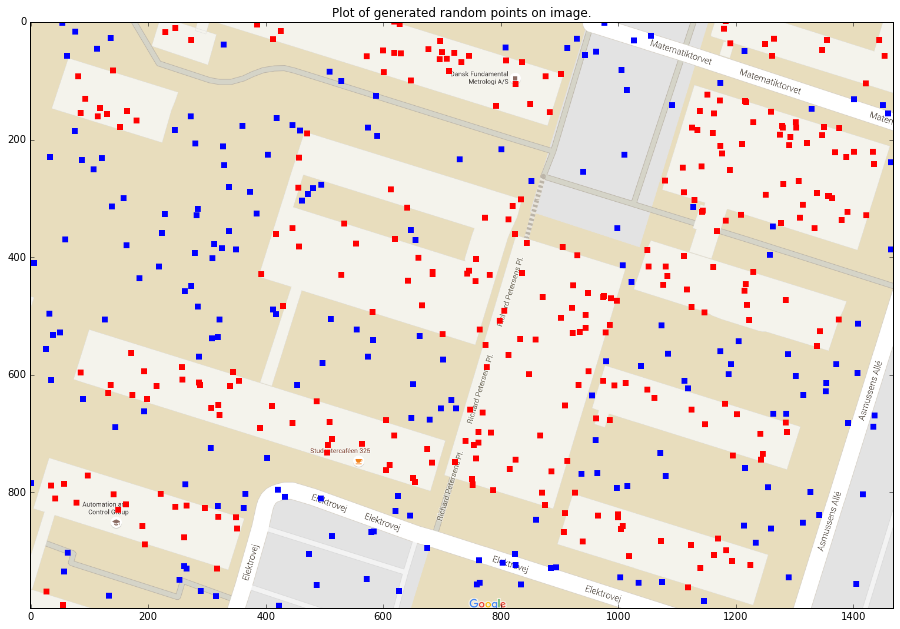

In [5]:
# Plot the generated dataset.
plot_map(points, im_org, pix_org, 'Plot of generated random points on image.')

#### 1.2.3 Noise or random errors
In Video 2, Arek Stopczynski indicates that noise can be countered by collecting more data, as the average or mean is centered around the true value. This can be visualized using the functions created earlier. Histograms are convenient plotting mechanisms for demonstrating this behavior. The mean and standard deviation are also produced as outputs of our function, which allows us to plot a new map to show the updated resultset.

mean = 0.60016, std = 0.0270060067392.


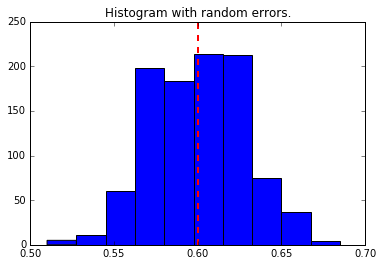

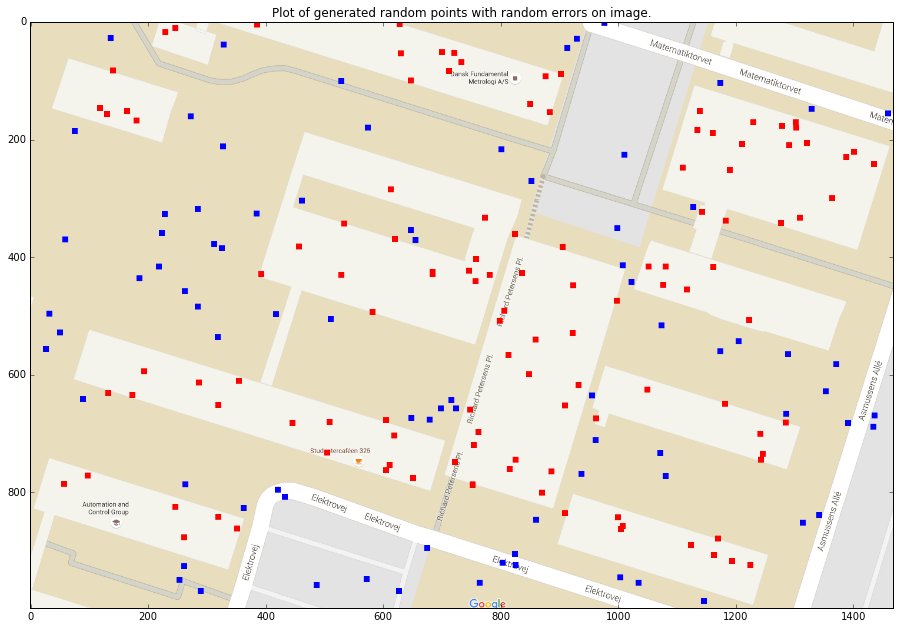

In [6]:
# Demonstrate random error.
random_error_points = calculate_random_error(points, k=1000)
plot_map(random_error_points, im_random_error, pix_random_error, 'Plot of generated random points with random errors on image.')

#### 1.2.4 Bias or systematic errors
When there are systematic errors (bias) present in your dataset, you will need to employ alternate methods to clean your data. Take note of the shift in the histogram where it is no longer centered around the mean. As per the previous example, the mean and standard deviation are produced, as well as the updated map.

mean = 0.51228, std = 0.0265386812031.


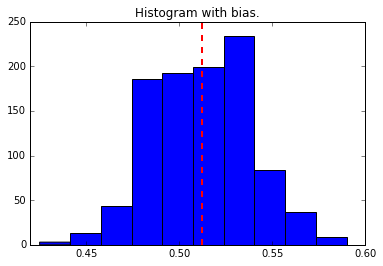

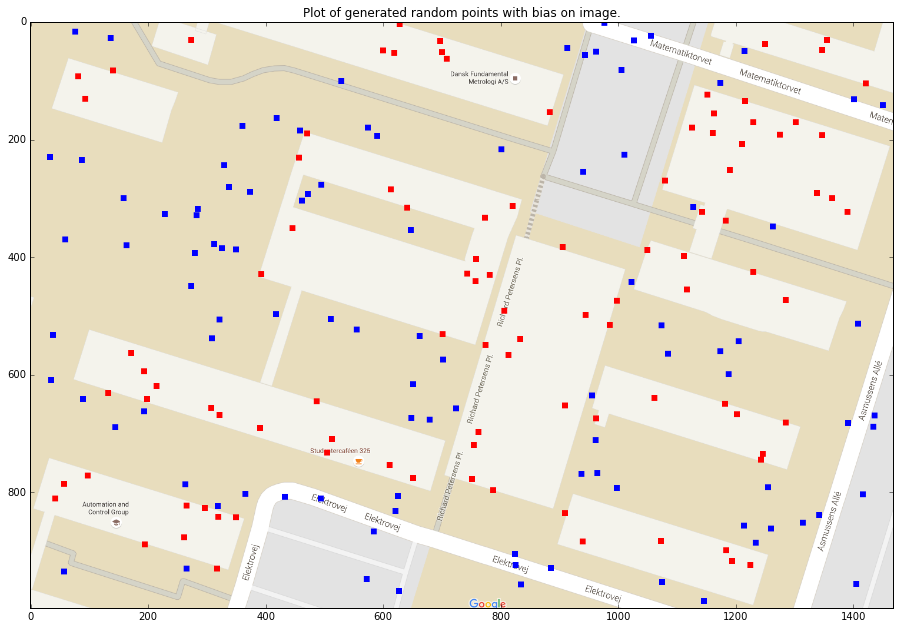

In [7]:
# Demonstrate bias.
bias_points = calculate_bias(points, k=1000, bias=0.6)
plot_map(bias_points, im_bias, pix_bias, 'Plot of generated random points with bias on image.')

<br>
<div class="alert alert-info">
<b>Exercise 1 Start.</b>
</div>

### Instructions
> Assume that the "outside" data points in the previous example are accurate. How would you go about cleaning the "bias_points" if this were the only dataset you had?

> **Hint**: 

> Your answer can be a written, logical answer and you do not need to perform any calculations for grading purposes.



Check the points inside buildings. Where there are much more points in one building than the building should have, remove the surplus points. Get the proportion of the surplus points in one building by comparing the proportion of the building area to the whole map area with the proportion of the points inside the building to the whole map points.

<br>
<div class="alert alert-info">
<b>Exercise 1 End.</b>
</div>

> **Exercise complete**:
    
> This is a good time to "Save and Checkpoint".

<br>
<div class="alert alert-info">
<b>Exercise 2 [Advanced] Start.</b>
</div>

### Instructions
> Plot what happens with estimated value (mean + shaded std) when you increase the number of datapoints in:

> 1. noisy data, and 

> 2. biased data. 

> **Note**:

> This activity is for advanced users only and extra credit will be allocated. Standard users will not be penalized for not completing this activity.

mean = 0.600152, std = 0.0266100901163.


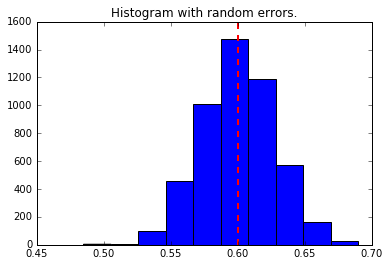

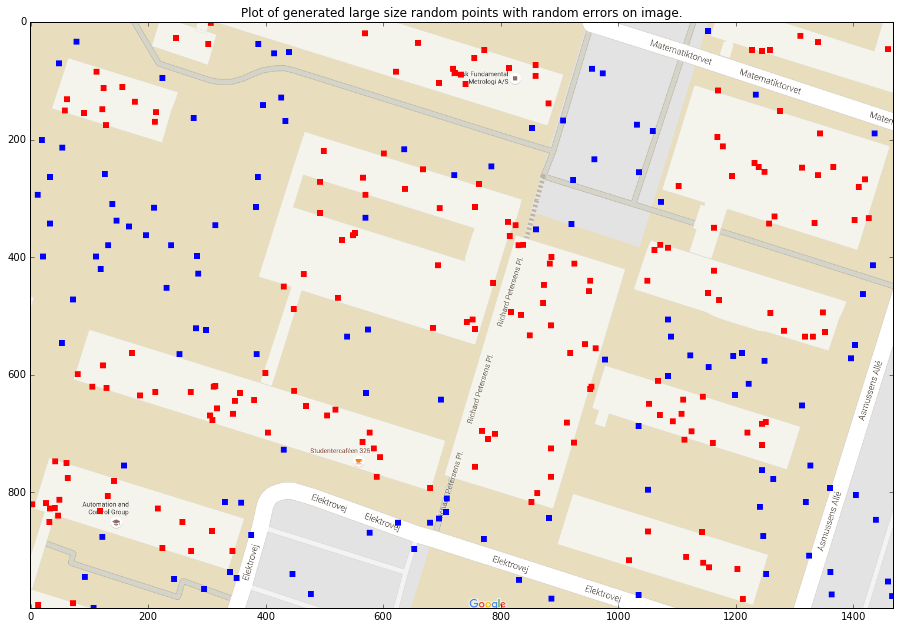

In [8]:
# Repeat section 1.2.3 with your changes here.
random_error_points = calculate_random_error(points, k=5000)
plot_map(random_error_points, im_random_error, pix_random_error, 'Plot of generated large size random points with random errors on image.')

Your markdown notes on changes applied to section 1.2.3 and interpretation of results here.

mean = 0.511724, std = 0.0267923090457.


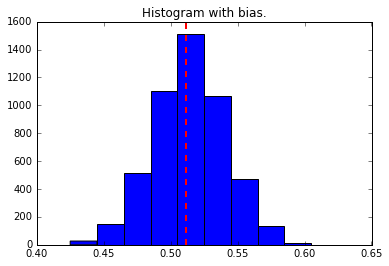

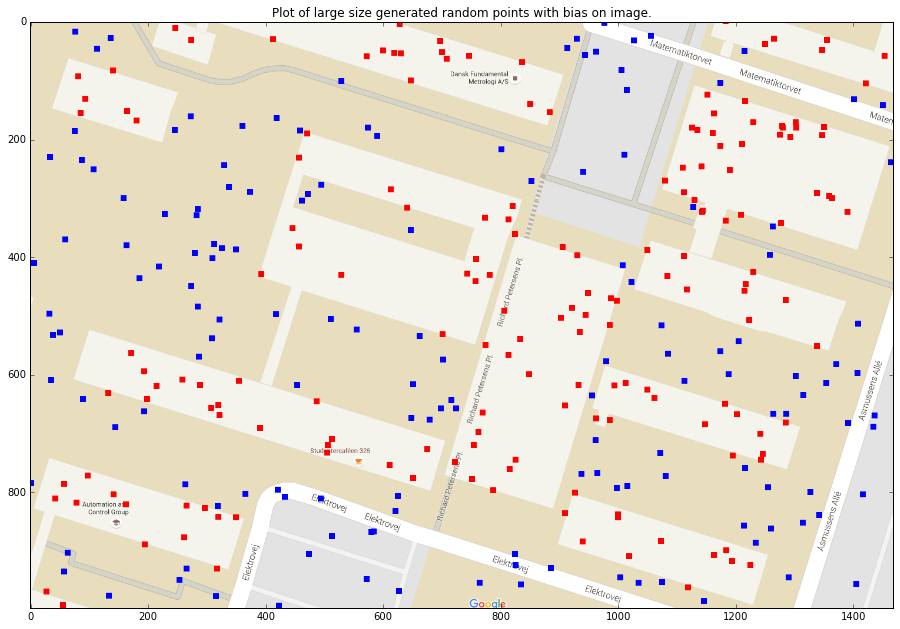

In [8]:
# Repeat section 1.2.4 with your changes here.
bias_points = calculate_bias(points, k=5000, bias=0.6)
plot_map(bias_points, im_bias, pix_bias, 'Plot of large size generated random points with bias on image.')

Your markdown notes on changes applied to section 1.2.4 and interpretation of results here.

<br>
<div class="alert alert-info">
<b>Exercise 2 End.</b>
</div>

> **Exercise complete**:
    
> This is a good time to "Save and Checkpoint".

## 2. Bonus: Introduction to PIL
While you will not spend much time on this library in this course, this section of the notebook serves as a brief introduction to the Python Imaging Library, as it was utilized in the previous section. Many of you may not be aware of the wide range of potential uses of Python, and the options that exist. In the previous example an image was used as an input file. Points were then classified as inside or outside, based on the pixel color of the randomly generated points on the image.

You can obtain similar images from [Google maps](https://www.google.co.za/maps/place/Dansk+Fundamental+Metrologi+A%2FS/@55.7839786,12.5174761,18.5z/data=!4m5!3m4!1s0x46524e7d0398546f:0xcc373daed6ed3e95!8m2!3d55.7846082!4d12.5183756?hl=en) and perform some basic data exploration and wrangling functions. You will need to update the colors used in the functions to reflect those present in your image. It is therefore advised that you select a basic image with few color variations.

In the previous example it was assumed that everyone was outside, and the status was updated if the color matched a building. This is much easier than trying to account for all the possible variations in color that you may come across.

> **Note**:

> The simplistic approach applied in this trivial example **does not scale and should not be used for image processing**. Image processing is outside the scope of this course and requires different tools and infrastructure configurations than that provisioned for this course. Attempts to perform non-trivial operations on your virtual analysis environment may result in depletion of resources required to complete this course and should be avoided.

In the following example Python tools and libraries are used to wrangle the data. This example therefore starts with the question of which colors are present in the image.
1. Create a dictionary of colors.
2. Create a sorted list in order to find the most prevalent color.
3. Change the image, where one color is substituted for another.

While this example is by no means extensive in demonstrating the capabilities of either Python or the PIL library, it’s aim is to emphasize that input data does not always have to be traditional data files.

#### 2.1 Load the image again
Start by importing the same image used previously, and display some basic information about the image.

In [9]:
im = Image.open("dtu_map.png")
print im.format, im.size, im.mode

PNG (1468, 997) RGBA


#### 2.2 Create a list of colors present in the image
Create a sorted list and display the five RGBA colors observed most frequently in reversed, sorted order.

In [10]:
# Create color dictionary.
colors = {}
for color in im.getdata():
    colors[color] = colors.get(color, 0) + 1

# Create sorted list.
sorted_c = sorted(colors.items(), key=operator.itemgetter(1), reverse=True)

# Display the first 5 records of the list.
sorted_c[:5]    

[((232, 221, 189, 255), 735549),
 ((244, 243, 236, 255), 482843),
 ((227, 227, 227, 255), 123193),
 ((255, 255, 255, 255), 48821),
 ((213, 212, 200, 255), 16077)]

#### 2.3 Substitute one color for another and display the updated image.
Replace the color used to identify buildings, RGBA color (244, 243, 236, 255), in the previous example, with another, (50, 50, 255, 255). You can search for RGBA color codes and replace the second, (50, 50, 255, 255), with a color or your choice should you wish to do so.

In [11]:
# Obtain pixel data and replace a specific color in the image with another.
pixdata = im.load()

# Change the building color
for y in xrange(im.size[1]):
    for x in xrange(im.size[0]):
        if pixdata[x, y] == (244, 243, 236, 255):    # check for current building color
            pixdata[x, y] = (50, 50, 255, 255)       # replace with new color

# The lines below have been commented out as we include this image in course material. 
#   Advanced students can uncomment the relevant portions to save and display their images with alternative colors.

# Save the updated image.
# im.save('updated_file.png')

# Show the updated image.
# im.show()

Let's take a look at our updated image:

![Updated image](updated_file.png "Image with the building color changed to blue.")

> **Exercise complete**:
    
> This is a good time to "Save and Checkpoint".

## 3. Submit your notebook

Please make sure that you:
- Perform a final "Save and Checkpoint";
- Download a copy of the notebook in ".ipynb" format to your local machine using "File", "Download as" and "IPython Notebook (.ipynb)";
- Submit a copy of this file to the online campus.